In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import vcf
import pandas as pd
from germline_cnv_evaluation import GenericCNVCallSet, GenericCopyNumberVariant

In [3]:
hg00514_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/ILL_PB_RO.5.HG00514.bed'
hg00733_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/ILL_PB_RO.5.HG00733.bed'
na19240_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/ILL_PB_RO.5.NA19240.bed'

In [4]:
hg00514_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/genotyped-segments-HG00514_1.cram.samtools.vcf'
hg00733_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/genotyped-segments-HG00733_1.cram.samtools.vcf'
na19240_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/genotyped-segments-NA19240.samtools.vcf'

In [5]:
hg00514_ms_seg_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/HG00514_1.cram.samtools.called.seg'
hg00733_ms_seg_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/HG00733_1.cram.samtools.called.seg'
na19240_ms_seg_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/NA19240.samtools.called.seg'

In [6]:
def generate_truth_call_set_and_caller_map_from_bed(truth_bed_file, sample_name):
    truth_bed_pd = pd.read_csv(truth_bed_file, sep='\t', header=None)
    call_set = GenericCNVCallSet(sample_name)
    caller_map = {}
    for record in truth_bed_pd.values:
        contig = record[0]
        start = int(record[1]) + 1
        end = int(record[2])
        sv_type = record[3]
        var_copy_number = -1
        if sv_type == 'DEL':
            genotype = 'del'
        elif sv_type == 'CNV':
            genotype = 'cnv'
        else:
            continue
        quality = 99
        var = GenericCopyNumberVariant(contig, start, end, var_copy_number, quality, genotype=genotype)
        callers = record[4].split(',')
        call_set.add(var)
        caller_map[var] = callers
    
    return call_set, caller_map

In [7]:
def generate_call_set_from_gcnv_vcf(gcnv_vcf_file):
    allele_to_genotype_map = {'N': 'ref', '<DEL>': 'del', '<DUP>': 'dup'}
    quality_mode: str = "some"
    with open(gcnv_vcf_file, 'r') as f:
        vcf_reader = vcf.Reader(f)
        sample_name = vcf_reader.samples[0]
        gcnv_call_set = GenericCNVCallSet(sample_name)

        for record in vcf_reader:
            info = record.INFO
            contig = record.CHROM
            start = record.start + 1
            end = info['END']

            var_copy_number = record.samples[0]['CN']
            genotype_index = int(record.samples[0]['GT'])
            allele = str(record.alleles[genotype_index])
            num_intervals = record.samples[0]['NP']
            genotype = allele_to_genotype_map[allele]

            if quality_mode == "some":
                quality = num_intervals * record.samples[0]["QS"]
            elif quality_mode == "all":
                quality = record.samples[0]["QA"]
            else:
                raise Exception("Unknown quality calculation mode -- valid options are \"some\" and \"all\"")

            # generate variant
            if genotype != 'ref':
                sample_var = GenericCopyNumberVariant(contig, start, end, var_copy_number, quality,
                                                      genotype=genotype,
                                                      num_intervals=num_intervals,
                                                      variant_frequency=None,
                                                      variant_class=None)
                gcnv_call_set.add(sample_var)
    
    return gcnv_call_set

In [8]:
def generate_call_set_from_ms_seg(ms_seg_file, sample_name):
    call_to_genotype_map = {'0': 'ref', '-': 'del', '+': 'dup'}
    with open(ms_seg_file, 'r') as f:
        ms_seg_pd = pd.read_csv(f, sep='\t', comment='@')
        ms_call_set = GenericCNVCallSet(sample_name)
        for _, record in ms_seg_pd.iterrows():
            contig = record['CONTIG']
            start = record['START']
            end = record['END']
            var_copy_number = -1
            genotype = call_to_genotype_map[record['CALL']]
            if genotype == 'ref':
                continue
            quality = 99
            var = GenericCopyNumberVariant(contig, start, end, var_copy_number, quality, genotype=genotype)
            ms_call_set.add(var)
    return ms_call_set

In [9]:
hg00514_tuple = ('HG00514_1', hg00514_truth_bed_file, hg00514_gcnv_vcf_file, hg00514_ms_seg_file)
hg00733_tuple = ('HG00733_1', hg00733_truth_bed_file, hg00733_gcnv_vcf_file, hg00514_ms_seg_file)
na19240_tuple = ('NA19240', na19240_truth_bed_file, na19240_gcnv_vcf_file, na19240_ms_seg_file)

In [10]:
# See https://www.biorxiv.org/content/biorxiv/early/2017/09/23/193144.full.pdf for discussion of the callers
# included in the consensus call sets
sv_callers = ['ForestSV', 'lumpy', 'Manta', 'novoBreak', 'Pindel', 'SVelter', 'VH', 'wham']
liwgs_callers = ['Delly', 'liWGS', 'MELT']
cnv_callers = ['dCGH', 'GenomeStrip', 'GATK gCNV', 'GATK ModelSegments']

In [11]:
call_sets = {}
for sample_name, truth_bed_file, gcnv_vcf_file, ms_seg_file in [hg00514_tuple, hg00733_tuple, na19240_tuple]:
    truth_call_set, truth_caller_map = generate_truth_call_set_and_caller_map_from_bed(truth_bed_file, sample_name)
    gcnv_call_set = generate_call_set_from_gcnv_vcf(gcnv_vcf_file)
    ms_call_set = generate_call_set_from_ms_seg(ms_seg_file, sample_name)
    call_sets[sample_name] = (truth_call_set, truth_caller_map, gcnv_call_set, ms_call_set)
    print('Call sets created for', sample_name)

Call sets created for HG00514_1
Call sets created for HG00733_1
Call sets created for NA19240


In [12]:
from collections import Counter, defaultdict

min_overlap_fraction = 0.5
min_truth_lengths = [0, 250, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

sensitivity_curves = defaultdict(list)
for min_truth_length in min_truth_lengths:
    num_tot = 0
    num_TP_gcnv = 0
    num_FN_gcnv = 0
    num_miss_gcnv = 0
    num_wrong_gcnv = 0
    num_TP_ms = 0
    num_FN_ms = 0
    num_miss_ms = 0
    num_wrong_ms = 0
    num_TP_callers = Counter()
    
    for truth_call_set, truth_caller_map, gcnv_call_set, ms_call_set in call_sets.values():
        for contig in gcnv_call_set.contig_set:
            for var in truth_call_set.iter_in_contig(contig):
                if var.length_gte_value(min_truth_length):
                    num_tot += 1
                    for caller in truth_caller_map[var]:
                        num_TP_callers[caller] += 1
                    overlapping_vars_gcnv = gcnv_call_set.get_overlapping_variants_set(var, 'other', min_overlap_fraction=min_overlap_fraction)
                    if len(overlapping_vars_gcnv) == 0:
                        num_miss_gcnv += 1
                        num_FN_gcnv += 1
                        continue
                    for overlapping_var_gcnv, _ in overlapping_vars_gcnv:
                        if not ((var.genotype == 'del' and overlapping_var_gcnv.genotype == 'del') or 
                                (var.genotype == 'cnv' and (overlapping_var_gcnv.genotype == 'del' or overlapping_var_gcnv.genotype == 'dup'))):
                            num_wrong_gcnv += 1
                            num_FN_gcnv += 1
                            break
                    else:
                        num_TP_gcnv += 1
                        
            for var in truth_call_set.iter_in_contig(contig):
                if var.length_gte_value(min_truth_length):
                    overlapping_vars_ms = ms_call_set.get_overlapping_variants_set(var, 'other', min_overlap_fraction=min_overlap_fraction)
                    if len(overlapping_vars_ms) == 0:
                        num_miss_ms += 1
                        num_FN_ms += 1
                        continue
                    for overlapping_var_ms, _ in overlapping_vars_ms:
                        if not ((var.genotype == 'del' and overlapping_var_ms.genotype == 'del') or 
                                (var.genotype == 'cnv' and (overlapping_var_ms.genotype == 'del' or overlapping_var_ms.genotype == 'dup'))):
                            num_wrong_ms += 1
                            num_FN_ms += 1
                            break
                    else:
                        num_TP_ms += 1
                        
    print('gCNV:', min_truth_length, num_TP_gcnv, num_FN_gcnv, num_miss_gcnv, num_wrong_gcnv, num_TP_gcnv / num_tot)
    sensitivity_curves['GATK gCNV'].append((min_truth_length, num_TP_gcnv / num_tot))
    
    print('ModelSegments:', min_truth_length, num_TP_ms, num_FN_ms, num_miss_ms, num_wrong_ms, num_TP_ms / num_tot)
    sensitivity_curves['GATK ModelSegments'].append((min_truth_length, num_TP_ms / num_tot))
    
    for caller in sv_callers + ['GenomeStrip']:
        sensitivity_curves[caller].append((min_truth_length, num_TP_callers[caller] / num_tot))

gCNV: 0 1557 11853 11805 48 0.11610738255033556
ModelSegments: 0 4062 9348 8483 865 0.3029082774049217
gCNV: 250 1539 5261 5222 39 0.2263235294117647
ModelSegments: 250 3008 3792 3317 475 0.4423529411764706
gCNV: 500 1455 1511 1478 33 0.49055967633175995
ModelSegments: 500 1471 1495 1120 375 0.4959541469993257
gCNV: 1000 1224 904 885 19 0.575187969924812
ModelSegments: 1000 1057 1071 787 284 0.4967105263157895
gCNV: 2000 868 509 496 13 0.6303558460421206
ModelSegments: 2000 629 748 555 193 0.4567901234567901
gCNV: 3000 634 309 305 4 0.672322375397667
ModelSegments: 3000 418 525 414 111 0.4432661717921527
gCNV: 4000 510 240 238 2 0.68
ModelSegments: 4000 301 449 361 88 0.4013333333333333
gCNV: 5000 396 207 205 2 0.6567164179104478
ModelSegments: 5000 226 377 313 64 0.3747927031509121
gCNV: 6000 314 171 170 1 0.6474226804123712
ModelSegments: 6000 167 318 266 52 0.3443298969072165
gCNV: 7000 204 107 106 1 0.6559485530546624
ModelSegments: 7000 100 211 185 26 0.3215434083601286
gCNV: 8000

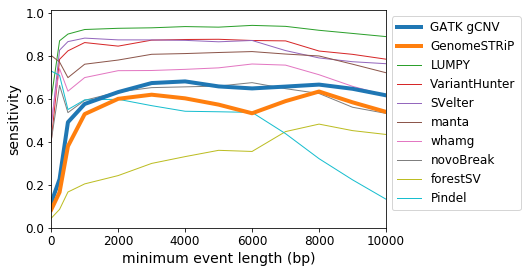

In [30]:
caller_to_label_map = {'GenomeStrip': 'GenomeSTRiP', 
                       'VH': 'VariantHunter', 
                       'wham': 'whamg', 
                       'ForestSV': 'forestSV',
                       'Manta': 'manta',
                       'lumpy': 'LUMPY'}

sv_callers_sorted_by_sensitivity_at_10kb = sorted(sv_callers, 
                                                  key=lambda c: sensitivity_curves[c][-1][1],
                                                  reverse=True)
for caller in ['GATK gCNV', 'GenomeStrip'] + sv_callers_sorted_by_sensitivity_at_10kb:
    sensitivity_curve = sensitivity_curves[caller]
    min_truth_lengths, sensitivity = zip(*sensitivity_curve)
    xlim([0, max(min_truth_lengths)])
    ylim([0, 1.01])
    plot(min_truth_lengths, sensitivity, 
         label=caller_to_label_map[caller] if caller in caller_to_label_map.keys() else caller,
         zorder=1 if caller in cnv_callers else 0,
         lw=4 if caller in cnv_callers else 1)
xlabel('minimum event length (bp)', fontsize=14)
ylabel('sensitivity', fontsize=14)
tick_params(axis='both', which='major', labelsize=12)
lgd = legend(bbox_to_anchor=(1, 1), fontsize=12)
savefig('/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/all-samples.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
show()